In [1]:
!pip install pafy youtube-dl moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00


In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2025-09-30 10:30:38.502678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759228238.739961      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759228238.811884      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_r

In [3]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

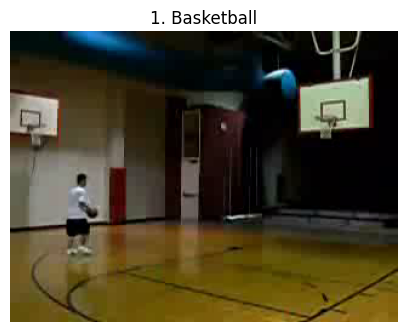

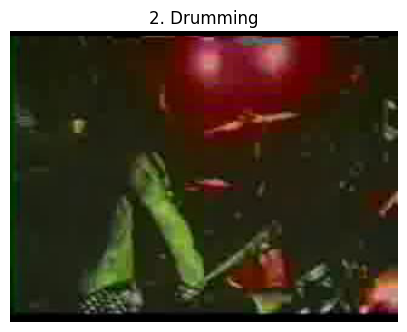

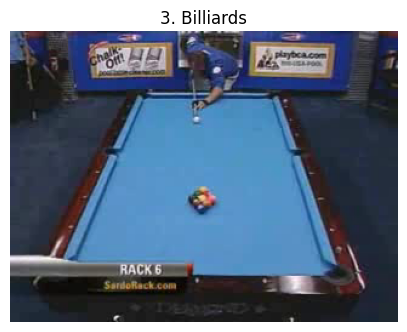

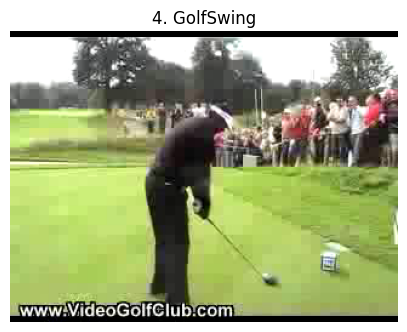

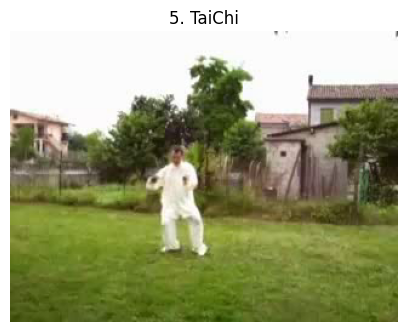

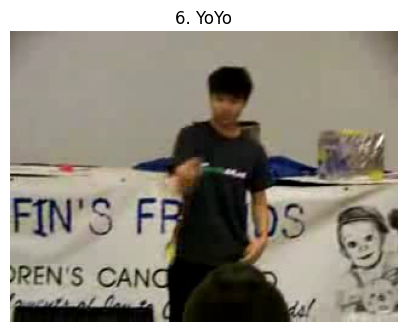

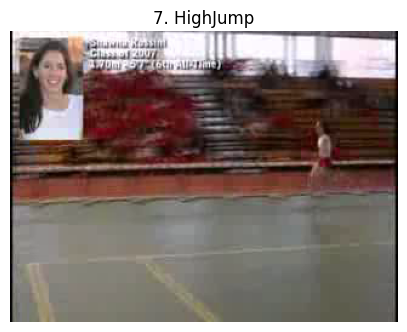

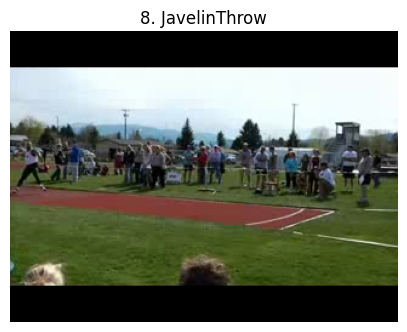

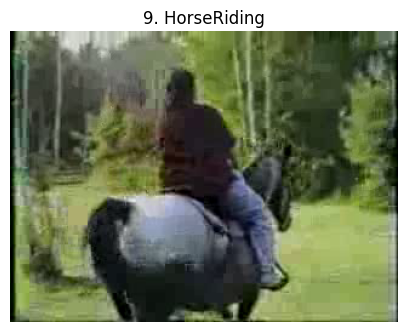

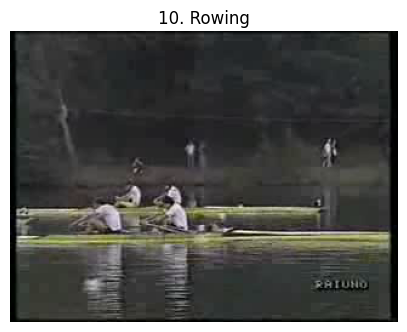

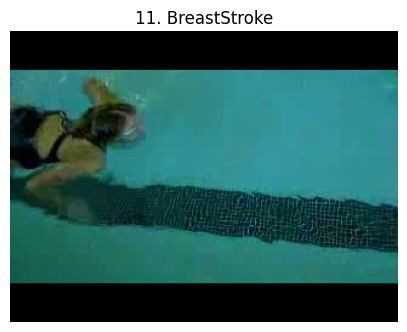

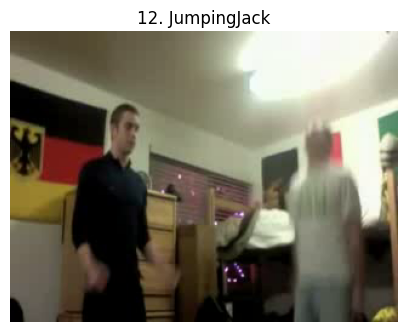

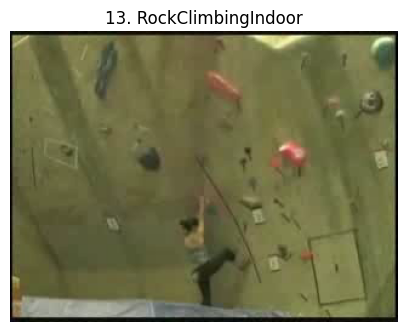

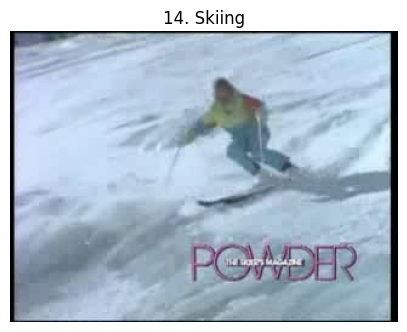

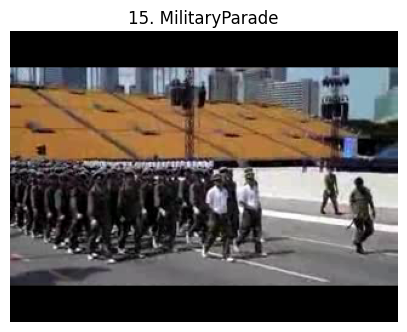

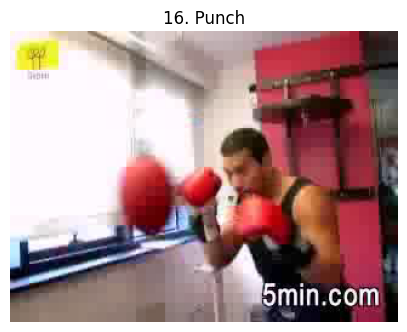

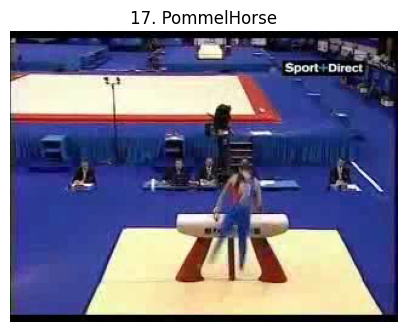

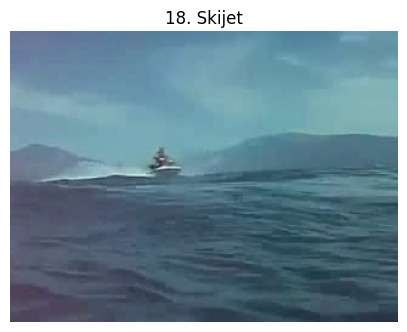

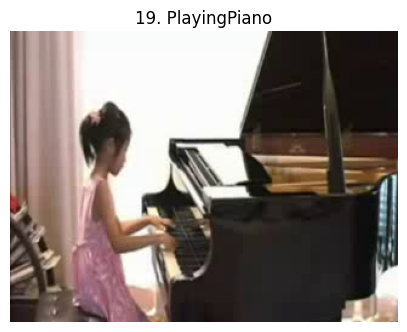

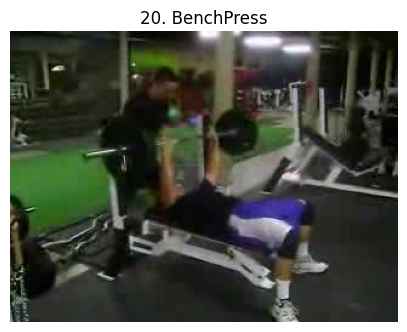

In [4]:
all_class_names = os.listdir('UCF50')
random_classes = random.sample(range(len(all_class_names)),20)
for counter,index in enumerate(random_classes,1):
  selected_class = all_class_names[index]
  file_name = os.listdir(f'UCF50/{selected_class}')
  selected_file = random.choice(file_name)
  video_file_path = f'UCF50/{selected_class}/{selected_file}'
  video_reader = cv2.VideoCapture(video_file_path)
  _,bgr = video_reader.read()
  bgr = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
  video_reader.release()
  plt.figure(figsize=(5,5))
  plt.title(f'{counter}. {selected_class}')
  plt.imshow(bgr)
  plt.axis('off')

In [5]:
height,width=244,244
sq_length =20
DIR = 'UCF50'
CLASSES_LIST=['HighJump','PoleVault']


In [6]:
def getframes(video_path):
  frames_list=[]
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/sq_length),1)
  for frame_counter in range(sq_length):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window)
    success,frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame,(height,width))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list


In [7]:
def get_dataset():
  features=[]
  labels=[]
  video_file_paths =[]
  for class_index,class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of class: {class_name}')
    files_list=os.listdir(os.path.join(DIR,class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DIR,class_name,file_name)
      frames = getframes(video_file_path)
      if len(frames) == sq_length:
        features.append(frames)
        labels.append(class_index)
        video_file_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)
  return features,labels,video_file_paths

In [8]:
features,labels,video_file_paths = get_dataset()

Extracting Data of class: HighJump
Extracting Data of class: PoleVault


In [9]:
category = to_categorical(labels)
category

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features,category , test_size = 0.25, shuffle = True, random_state = 42)

def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (20,
                                                                                      height, width, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    model.summary()
    return model

In [11]:
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

2025-09-30 10:33:15.240645: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 242, 242,   │         1,024 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 121, 121,   │             0 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 121, 121,   │             0 │
│ (TimeDistributed)               │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 119, 119,   │         3,488 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 60, 60, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 58, 58, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 29, 29, 14) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 29, 29, 14) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 27, 27, 16) │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 14, 14, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       125,442 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,442 (618.91 KB)

 Trainable params: 158,442 (618.91 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


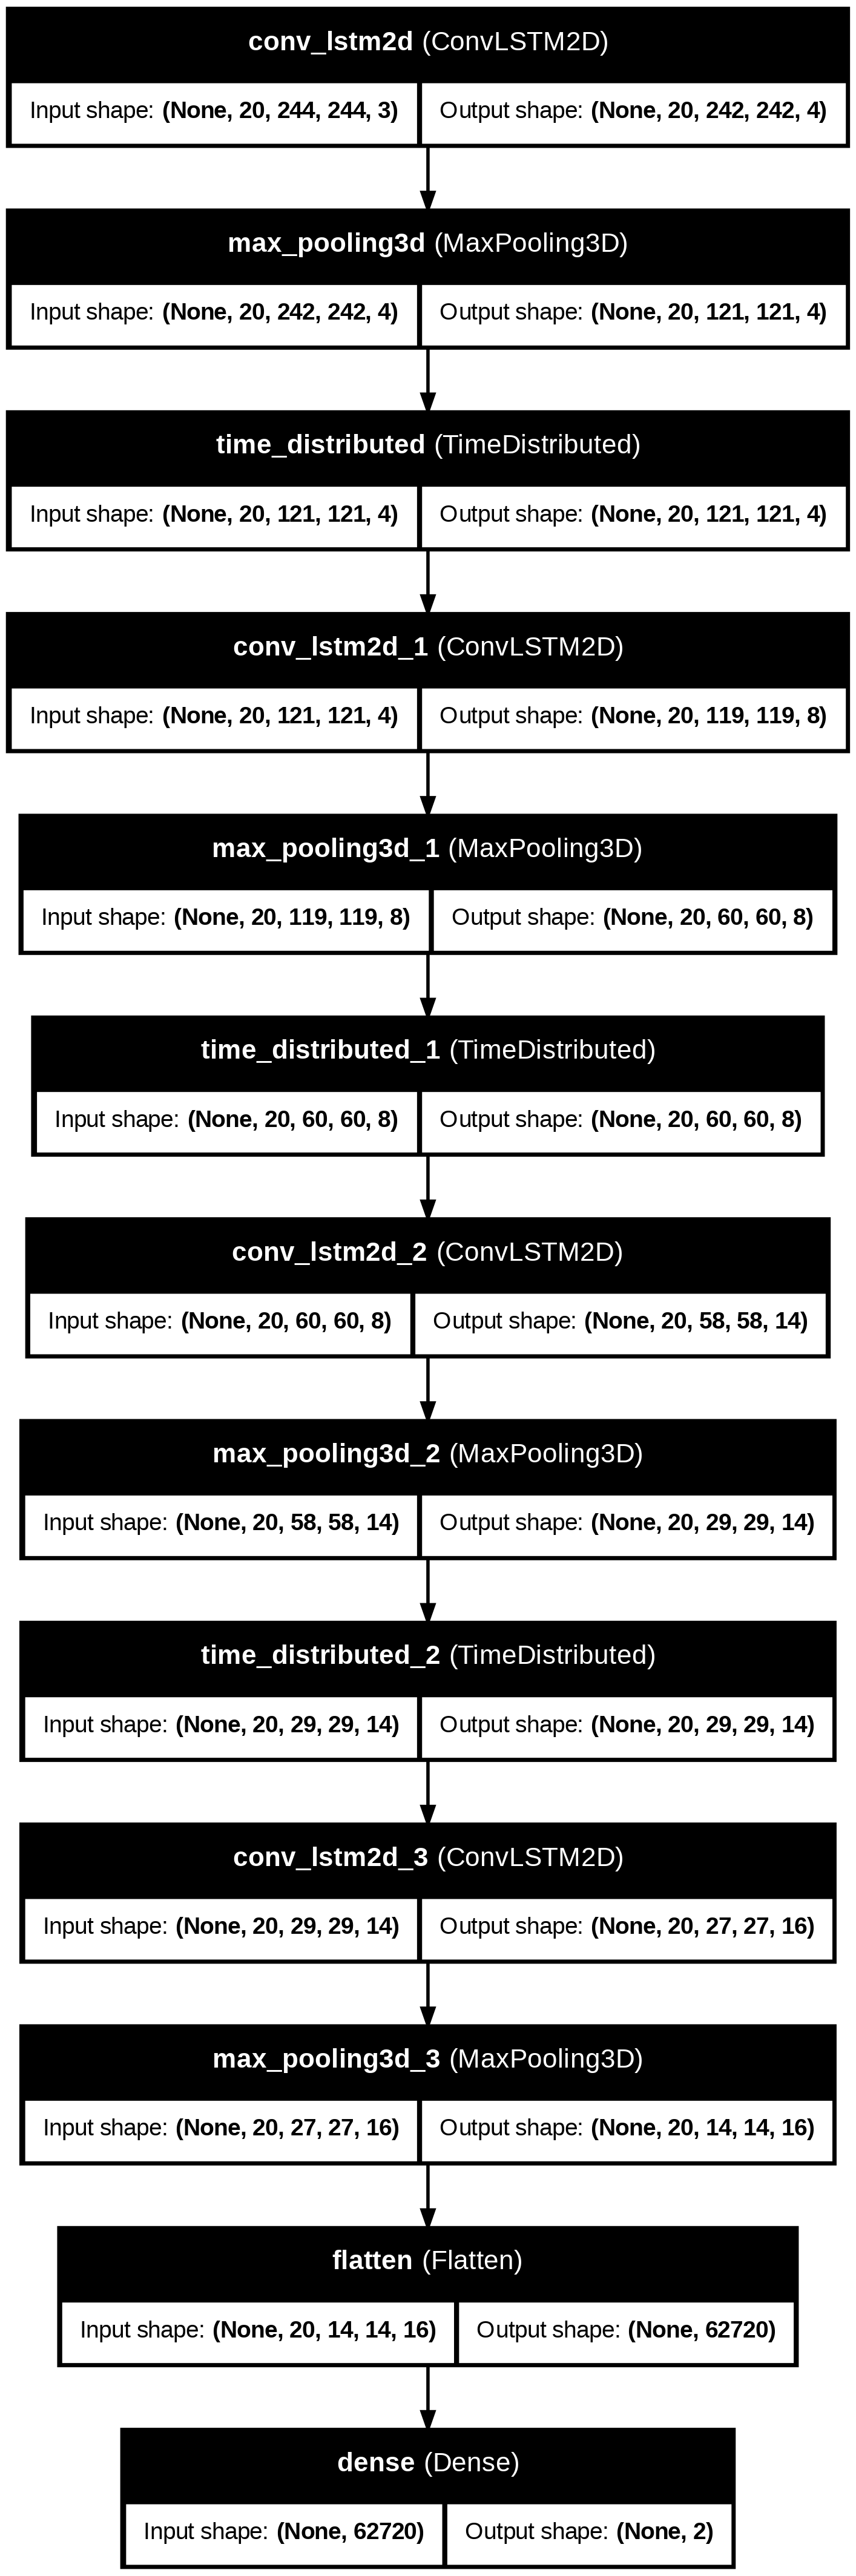

In [12]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [13]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 490s 11s/step - accuracy: 0.4948 - loss: 0.9112 - val_accuracy: 0.7674 - val_loss: 0.6318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 458s 11s/step - accuracy: 0.6874 - loss: 0.6331 - val_accuracy: 0.4884 - val_loss: 0.8427
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 455s 11s/step - accuracy: 0.6337 - loss: 0.6166 - val_accuracy: 0.7442 - val_loss: 0.5505
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 457s 11s/step - accuracy: 0.7554 - loss: 0.5323 - val_accuracy: 0.7674 - val_loss: 0.5503
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 468s 11s/step - accuracy: 0.6834 - loss: 0.5727 - val_accuracy: 0.7907 - val_loss: 0.5238
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 455s 11s/step - accuracy: 0.7728 - loss: 0.5327 - val_accuracy: 0.7442 - val_loss: 0.4201
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 456s 11s/step - accuracy: 0.7487 - loss: 0.5133 - val_accuracy: 0.7674 - val_loss: 0.4524
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 466s 11s/step - accuracy: 0.8231 - loss: 0.3910 - val_accuracy: 0.

In [14]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 14s/step - accuracy: 0.8663 - loss: 0.3277


In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

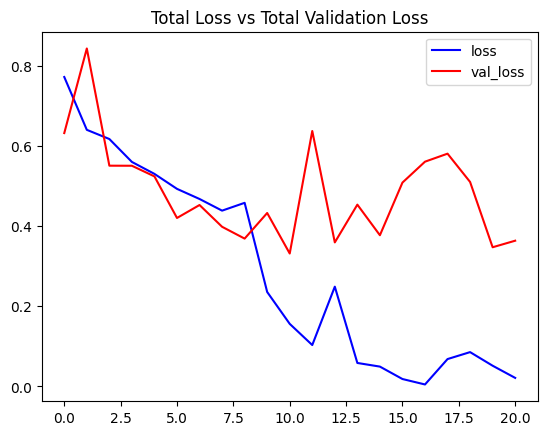

In [16]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

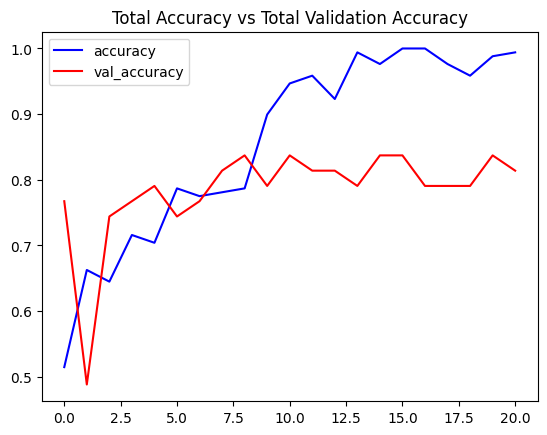

In [17]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')